# Forecasting Lorenz with DNN

## GPU check

In [2]:
import platform
platform.platform()

'macOS-13.3-arm64-arm-64bit'

In [3]:
import tensorflow as tf
tf.__version__

'2.11.0'

In [4]:
gpu = len(tf.config.list_physical_devices("GPU"))>0
gpu

True

In [5]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Generate data

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [7]:
# Create a function that takes a vector as input and returns (x_dot,y_dot,z_dot) evaluated at t and rho
def lorenz(t, x, rho):
    x = np.array([10*(x[1]-x[0]),
                  x[0]*(rho-x[2])-x[1],
                  x[0]*x[1]-8/3*x[2]])
    return x

In [8]:
# Create a list of evaluation points t_eval
dt = 0.01
tf = 100
num = tf/dt
t_eval = np.linspace(0,tf,int(num)).tolist()

In [9]:
# Create random initial values between 0 and 10
inits = np.random.rand(3)*10
inits = inits.tolist()

In [10]:
sol_rho10 = solve_ivp(lorenz, [0,1000], inits, t_eval=t_eval, args=(10,))
sol_rho28 = solve_ivp(lorenz, [0,1000], inits, t_eval=t_eval, args=(28,))
sol_rho40 = solve_ivp(lorenz, [0,1000], inits, t_eval=t_eval, args=(40,))

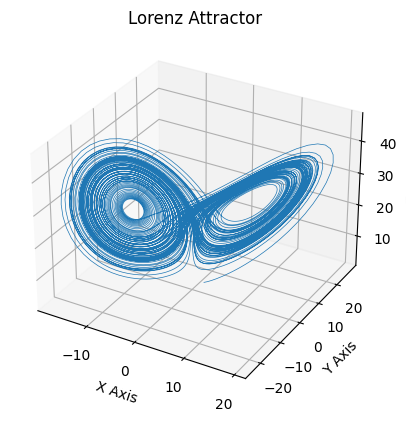

In [11]:
# Plot the data
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*sol_rho28.y, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

## Data Preprocessing

In [12]:
sol_rho28.y.T.shape

(10000, 3)

In [13]:
rho_10 = np.matrix([10]*10000)
rho_28 = np.matrix([28]*10000)
rho_40 = np.matrix([40]*10000)
# with shape (10000,1)

In [14]:
X_10 = np.concatenate((sol_rho10.y.T,rho_10.T), axis=1)
X_28 = np.concatenate((sol_rho28.y.T,rho_28.T), axis=1)
X_40 = np.concatenate((sol_rho40.y.T,rho_40.T), axis=1)
X = np.concatenate((X_10,X_28,X_40),axis=0)
X = X.T
# with shape (4,30000)

## Build Keras model

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

In [16]:
# Define the number of sigmoid activations in the hidden layer
H = 10

model1 = keras.Sequential([
    # 1 input -> 10 hidden sigmoids -> 1 linear output
    layers.Dense(units = H, activation = 'sigmoid', input_shape = (4,)),
    layers.Dense(units = H, activation = 'sigmoid',),
    layers.Dense(units = 4, activation = 'linear', use_bias = False)
])
# Show the model; the output layer has no bias, therefore, 10 weights only
model1.summary()

2023-03-27 21:37:33.928601: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-27 21:37:33.929139: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 4)                 40        
                                                                 
Total params: 200
Trainable params: 200
Non-trainable params: 0
_________________________________________________________________


## Get gradient and compute loss

In [165]:
def computeLoss(X, steps):
    # Split X into batches of size 10,000
    X1 = X[:,0:10000]
    X2 = X[:,10000:20000]
    X3 = X[:,20000:30000]
    
    loss = 0
    for s in range(steps): 
        
    

In [ ]:
def trainStep(X, opt, steps):
    
    # Gradient tape for model parameters
    with tf.GradientTape() as tape:
        tape.watch(model1.trainable_variables)
        
        # Compute the loss associated to current model
        loss = computeLoss(X, steps)
        
    # Compute the gradient of loss wrt model parameters
    grads = tape.gradient(loss, model1.trainable_variables)
    
    # Gradient step
    opt.apply_gradients(zip(grads, model1.trainable_variables))
    
    return loss

## Main training loop

In [ ]:
# Speed up function?
@tf.function
def trainLoop(X, epochs, steps):
    
    # Define an optimizer
    lr = tf.keras.optimizers.schedules.PolynomialDecay(0.1, epochs, 1e-4)
    opt = keras.optimizers.Adam(lr)
    
    # Define an empty numpy array to hold the loss at each epoch
    epoch_loss = np.zeros(epochs)
   
    # Main training loop
    for i in range(epochs):
            
            # Compute the loss and add to the total loss in the epoch
            PDEloss = trainStep(X,opt,steps)
            epoch_loss[i] += PDEloss
        
        # Print the loss at each epoch
        if np.mod(i, 100)==0 or i == 9999:
          print("PDE loss in {}th epoch: {: 1.4e}.".format(i, epoch_loss[i]))
    
    return epoch_loss

## Define epochs and train network

In [ ]:
from time import time

# Start timer
t0 = time()

# Define number of epochs and run training loop
epochs = 10000
loss = trainLoop(X, epochs, steps)

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

## Plot loss over epochs

In [ ]:
plt.semilogy(range(0, epochs), loss)
plt.xlabel('epochs')
plt.ylabel('loss')

plt.grid()
plt.show()